# <center>Optimal Protein Folding in the HP Model !</center>          
## <center>Diego Serra</center>

    

# BestFolds Algorithm

### Folding pathways generation

Therefore, I defined a function "Walking" that recursively generates all the non-crossing pathways and store them in a cache. Part of the code has been inspired with SAW on 2D square lattice done by "semenovandrew" on github.

In [1]:
steps = [(0,1), (0,-1), (1,0), (-1,0)] # Different possible moove.

def Walking(pathway, length, cache):
    """ The function will generate all the non-crossing possible paths and store them in a cache. Previously an empty cache has to be initiated.
        :pathway: list of tuples (First two positions of the path) the pathing start from (0,1) to avoid duplicates due to rotation of the structure.
        :lenght: int. lenght of the protein sequence.
        :cache: store all the pathways after recursion.
    """
    if length -2 == 0: # Base call, 2 is substracted for the first two residues that are constant /!\ Note that it's important to pass the two first positions in parameter. 
        cache.append(pathway)
    
    else:    
        for x,y in steps:
            previous_x, previous_y = pathway[-1]
            new_pathway = pathway.copy()
            following_position = (previous_x + x, previous_y + y)
            if following_position not in new_pathway: # Avoid crossing pathways
                new_pathway.append(following_position)
                Walking(new_pathway, length - 1, cache)

### H positions finding
<p>Then, based on the work Alantha Newman. We learn that boundings between hydrophobic residues can only occur between an even positioned H and an oddly positioned H, except if they are in contact (following in the sequence). Therefore, I decided to create a function that return the index of the the evenly and oddly positioned H separately.</p>

In [2]:
def HydrogenPosition(sequence):
    """The function returns all the even and odd hydrophobic residues positions respectively. Based on the assumption made in "Alantha Newman. 2002. A new algorithm for protein folding in the HP model. 
    In Proceedings of the thirteenth annual ACM-SIAM symposium on Discrete algorithms (SODA '02). Society for Industrial and Applied Mathematics, USA, 876–884.". 
    ":sequence: string of protein sequence of "H" and "P".
     :return: list of even and odd hydrophobic residues positions.
    """
    all_hpos = []
    sequence_list = list(sequence)
    for amino_acids in range(len(sequence_list)):
        if sequence_list[amino_acids] == 'H':
            all_hpos.append(amino_acids)
    
    even_hpos = [el for el in all_hpos if el%2 == 0]
    odd_hpos = [el for el in all_hpos if el%2 == 1]

    return even_hpos, odd_hpos

### Scoring
<P>The next step was to create a function that will score the H-H contacts on a given path. Therefore, I based my function on the idea that if the index of the path are not following, and their (row,col) positions are differing by only one unit, this means that the residues are bounded.</p> 

In [3]:
def Scoring(even_hpos, odd_hpos, path):
    """This function is used to calculate the folding score of the protein.
       :even_hpos: list of the even index of hydrophobic residues.
       :odd_hpos: list of the odd index of hydrophobic residues.
       :path: list of tuple of the folding pathway.
       :return: a score integer of folding for the given pathway in parameters and a list of the bounded residues two by two.
    """
    
    score = 0
    bounded_residues = []
    
    for even in even_hpos:
        
        for odd in odd_hpos:
            
            if abs(even-odd) != 1: # Do not follow
                
                col_diff = abs(path[even][1] - path[odd][1])
                row_diff = abs(path[even][0] - path[odd][0])
                
                if col_diff + row_diff == 1:
                    score += 1
                    bounded_residues.append([list(path[even]), list(path[odd])])
        
    return int(score), bounded_residues

### Folding

The folding function will basically return the best folding pathway generated from the walking function.  

<div class="alert alert-block alert-info">
    <b> Note:</b> A minimum of 4 residues must be given, otherwise an error message will be raised !
</div>

In [4]:
def Folding(sequence):
    """This function is used to return the best folding score and the best pathway and the list of the bounding residues associated.
       :sequence: string of protein sequence of "H" and "P".
       :return: the best folding score and its associated pathway.
    """
    
    if len(sequence) < 4:
        raise TypeError("There are not enough amino-acids to form an optimal folding ! Minimum 4 residues are needed... ")
    
    steps = [(0,1), (0,-1), (1,0), (-1,0)]
    cache = []
    Walking([(0,0), (0,1)], len(sequence), cache)
    
    
    even_hpos, odd_hpos = HydrogenPosition(sequence)
    
    best_score = 0
    best_path = []
    bounded_residues = []
    for path in cache:
        score, b_res = Scoring(even_hpos, odd_hpos, path)
        if score > best_score:
            best_score = score
            best_path = path
            bounded_residues = b_res
    return best_score, best_path, bounded_residues

### Shifting of the sequence

This function is used to translate horizontally and vertically all the positions to only have positive values. These value will be easier to put in a matrix for representation of the results.

In [5]:
def ShiftSequence(pathway, bounded_residues): 
    """The function is used to shift vertically and horizontally to avoid any negative values in the pathway. The pathway keeps 
       unchanged.
       :pathway: list of tuples of residues position.
       :bounded_residues: 2-levels list of the position of the residues that are binding (i.e., [[[rowi,coli],[rowj,colj]]]).
    """
    lateral_shifted_value = min(pathway)[0] # minimal value for the rows.
    vertical_shifted_value = min(pathway, key=lambda x:x[1])[1] # minimal value for the rows.
    
    pathway_list = []

    for el in pathway:
        pathway_list.append(list(el))
    
        
    row_shift = abs(0-lateral_shifted_value)
    col_shift = abs(0-vertical_shifted_value)
    shifted_pathway_list = []
    shifted_bounded_residues = []
    
    # Shifted positions and boundings generation 
    
    if lateral_shifted_value >= 0 and vertical_shifted_value >= 0 : # if the minimal values in rows and col are positive (then the left-bottom shift)
        for x,y in pathway_list:
            shifted_pathway_list.append([x - row_shift, y - col_shift])
    
        for bounds in bounded_residues:
            temp_bound = []
            for x,y in bounds:
                temp_bound.append([x-row_shift, y-col_shift])
            shifted_bounded_residues.append([temp_bound])
                
    elif lateral_shifted_value <= 0 and vertical_shifted_value <= 0:
        for x,y in pathway_list:
            shifted_pathway_list.append([x+row_shift, y+col_shift])
        
        for bounds in bounded_residues:
            temp_bound = []
            for x,y in bounds:
                temp_bound.append([x+row_shift, y+col_shift])
            shifted_bounded_residues.append([temp_bound])
            

    elif lateral_shifted_value >= 0 and vertical_shifted_value <= 0:
        for x,y in pathway_list:
            shifted_pathway_list.append([x-row_shift, y+col_shift])
            
        for bounds in bounded_residues:
            temp_bound = []
            for x,y in bounds:
                temp_bound.append([x-row_shift, y+col_shift])
            shifted_bounded_residues.append([temp_bound])
            
            
    elif lateral_shifted_value < 0 and vertical_shifted_value > 0:
        for x,y in pathway_list:
            shifted_pathway_list.append([x+row_shift, y-col_shift])
        
        for bounds in bounded_residues:
            temp_bound = []
            for x,y in bounds:
                temp_bound.append([x+row_shift, y-col_shift])
            shifted_bounded_residues.append([temp_bound])
    

        
    return  shifted_pathway_list, shifted_bounded_residues
    
    

### Matrix generation

This function will be used to generate the matrix and the matricial position of the residues + their contacts and the boundings. 

In [6]:
def CreateMatrix(shifted_pathway_list ,bounded_residues):
    """The function is used to generate a 0 matrix of correct size to let a space between each residues.
       Moreover, the function will also generate the matricial positions of all needed elements for representation.
       :shifted_pathway: list of each [row,col] positions of the pathway.
       :bounded_residues: 2-levels list of the position of the residues that are binding (i.e., [[[rowi,coli],[rowj,colj]]].
       :return: a 0-filled matrix.
                list of matricial position of residues.
                list of matricial contact positions.
                list of matricial bounding positions (horizontal and vertical boundings).
                   
    """
    
    matrice_shifted_pathway = []
    contact_positions = []

    bounded_v = [] # The positions of the vertical boundings
    bounded_h =[] # The positions of the horizontal boundings
    
    for i in range(len(shifted_pathway_list)): # Residues positions
        matrice_shifted_pathway.append([shifted_pathway_list[i][0] * 2, shifted_pathway_list[i][1]*2])
    
    # I take the max value to avoid having negative value in the contact positions

    for i in range(len(shifted_pathway_list)-1): # Contact (*) positions, starting at index 1 because (0,0) must not be affected
        if shifted_pathway_list[i][0] != shifted_pathway_list[i+1][0]:# If the movement is a row move then, the contact pos will affect only the row and not the col
            contact_positions.append([max(shifted_pathway_list[i][0], shifted_pathway_list[i+1][0])*2-1, shifted_pathway_list[i][1]*2])
        elif shifted_pathway_list[i][1] != shifted_pathway_list[i+1][1]:# If the movement is a col move then, the contact pos will affect only the col and not the col
            contact_positions.append([shifted_pathway_list[i][0]*2, max(shifted_pathway_list[i][1], shifted_pathway_list[i+1][1])*2-1])
    
    # Generation of boundings positions
    
    for bound in bounded_residues:
        
        temp_bound = []
        for el in bound:
            
            for x,y in el:

                temp_bound.append([x*2,y*2])

            if temp_bound[0][0] == temp_bound[1][0]: # It means that it's an horizontal bound "-". 
                val = temp_bound[0][1] + temp_bound[1][1] # The bound is between the residues
                temp_bound =[temp_bound[0][0], int(val/2)]
                bounded_h.append(temp_bound)

            elif temp_bound[1][0] == temp_bound[1][0]: # It means that it's an vertical bound "|".
                val = temp_bound[0][0] + temp_bound[1][0]
                temp_bound = [int(val/2),temp_bound[0][1]]
                bounded_v.append(temp_bound)   
        
        
    # Generation of an empty matrix filled with 0 
    
    matrice_row = max(matrice_shifted_pathway, key= lambda x:x[0])[0] +1
    matrice_col = max(matrice_shifted_pathway, key= lambda x:x[1])[1] +1
    
    matrice = [[0 for i in range(matrice_col)]for j in range(matrice_row)]
    
    return matrice, matrice_shifted_pathway, contact_positions, bounded_h, bounded_v

### Placement of the elements on the matrix

This step is used to place all elements in the matrix for further representation.
-  Contacts  = <b> * </b>
-  Horizontal bound = <b> - </b>
-  Vertical bound = <b> | </b>

In [7]:
def ResiduesBoundingPlacement(sequence, matrice, matrice_shifted_pathway, contact_positions, bounded_h, bounded_v):
    """The function places all the elements in a matrix.
       :sequence: string of protein sequence of "H" and "P".
       :matrice: a 0-filled matrix.
       :matrice_shifted_pathway: list of matricial position of residues.
       :contact_positions:  list of matricial contact positions.
       :bounded_h:list of matricial bounding horizontal positions.
       :bounded_v:list of matricial bounding vertical positions.
       :return: the final completed matrix.
    """
    
    sequence_list = list(sequence)
    matrice_shifted_pathway_row = []
    matrice_shifted_pathway_col = []
    contact_positions_row =[]
    contact_positions_col = []
    
    for x,y in matrice_shifted_pathway: # Crée 2 listes avec les coordonnées dans les ordres correspondants --> pour zip
        matrice_shifted_pathway_row.append(x)
        matrice_shifted_pathway_col.append(y)
        
    
    for x,y,res in zip(matrice_shifted_pathway_row, matrice_shifted_pathway_col, sequence_list): # adding the residues
        matrice[x][y] = res
    for x,y in contact_positions:
        matrice[x][y] = '*'
    for x,y in bounded_h:
        matrice[x][y] = '-'
    for x,y in bounded_v:
        matrice[x][y] = '|'
    
    
    return matrice

### Representation of the final result

This small function will be used to print out the result in the console

In [8]:
def PrintMatrix(matrix):
    """The function is used to loop over the matrix and print out the matrix.
       :matrix: matrix with all the element positionned.
    """
    
    for row in matrix:
        for col in row:
            if col == 0:
                print(" ", end="")
            else:
                print(col, end='')
        print()

### Final BestFolds function

In [9]:
def BestFolds(sequence): 
    """Final function 
    """
    
    # Generate one of the best folding score, best_path, list of bounded_residues.
    best_score, best_path, bounded_residues = Folding(sequence)
    
    # Shift sequence to keep only positive positions.
    shifted_pathway_list, shifted_bounded_residues= ShiftSequence(best_path, bounded_residues)
    
    # Generate the empty matrix and the list of matricial positions.
    matrix, matrice_shifted_pathway, contact_positions, bounded_h, bounded_v = CreateMatrix(shifted_pathway_list, shifted_bounded_residues)

    
    # Places the residues, the contacts and the boundings into the matrix
    
    final_matrix = ResiduesBoundingPlacement(sequence, matrix, matrice_shifted_pathway, contact_positions, bounded_h, bounded_v)
    
    # Display the folding
    print("Your best score is:", best_score)
    print("")
    PrintMatrix(final_matrix)
    

### Solutions

Following are the solutions asked for the project.

In [16]:
BestFolds("HPHHHHPPHPPH")

Your best score is: 5

  H*P  
  | *  
P*H-H*H
* | | *
P*H-H*H
  * *  
  P*P  


In [17]:
BestFolds("HPPHPHP")

Your best score is: 2

P*H-H*P
  * | *
  P*H*P


In [18]:
BestFolds("HHHHHHHHH")

Your best score is: 4

H*H*H
| | *
H*H*H
* | |
H*H*H


In [19]:
BestFolds("HHHPHPPHPHPPHHHPH")

Your best score is: 8

    H*P  
    | *  
P*H*H*H  
* | | |  
P*H-H*H*H
  * | | *
  P*H-H*P
    * *  
    P*P  


# Plotting the runtime of the function

In [11]:
import timeit
import matplotlib.pyplot as plt
import random
import time

In [12]:
def RandomSequence(length):
    """The function will return a random sequence string of "H" and "P".
       :length: lenght of the desired sequence.
       :return: random string.
    """
    sequence_list = random.choices(["H","P"], k = length)
    sequence_str = "".join(sequence_list)
    return sequence_str

In [13]:
def plotruntime(f,maxlength, trials, figsize = [5,5]):
    """
    The function plots de runtime for the folding function.
    :f: function used in the statement of the timeit function.
    :maxlenght: maximum length sequence desired for the plot.
    :trials: number of different sequence of length n assessed. The value will be averaged.
    :figsize: desired plot size.
    """
    
    times=[]
    seq_length=[]
    for i in range(4,maxlength+1): # the plot start from 4 residues, minimum needed for a folding.
        
        temp_list = []
        
        for j in range(trials):
            
            rd_seq = RandomSequence(i) # Generate each time a random sequence of length i for assessing the runtime.
            time = timeit.timeit(stmt=lambda:f(rd_seq), number=4)/4
            temp_list.append(time)
        
        temp_time = sum(temp_list)/trials # Average time for a given sequence length.
        times.append(temp_time) # Add the mean times to the times list.
        seq_length.append(i)
        print("Mean time for:",i, "residues",temp_time, "seconds")

    #Plot construction

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(seq_length,times, 'g')
    ax.set_xlabel("Sequence length")
    ax.set_ylabel("Runtime [s]")

Mean time for: 4 residues 5.050000000006438e-05 seconds
Mean time for: 5 residues 0.0001051499999999983 seconds
Mean time for: 6 residues 0.0005844999999999878 seconds
Mean time for: 7 residues 0.002244849999999965 seconds
Mean time for: 8 residues 0.011273074999999966 seconds
Mean time for: 9 residues 0.01641680000000001 seconds
Mean time for: 10 residues 0.04110114999999992 seconds
Mean time for: 11 residues 0.045199875 seconds
Mean time for: 12 residues 0.18687969999999998 seconds
Mean time for: 13 residues 0.763837925 seconds
Mean time for: 14 residues 2.9640931499999996 seconds
Mean time for: 15 residues 17.608160325 seconds


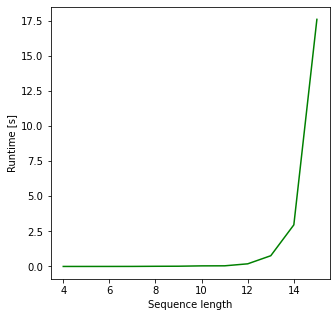

In [14]:
plotruntime(Folding,15,1)

<div class="alert alert-block alert-warning">
    <b> Note:</b> Exceeding 15 residues the algorithm takes too much time!
</div>

# Branch and Bound algorithm

One possible way to reduce the number of generated pathways is to suppress the one that are symmetrical either vertically, horizontally or by rotation.
<p>For a {x,y}:</p>

-  if <b>horizontal</b> symmetry {x,-y}.
-  if <b>vertical</b> symmetry {-x,y}.
-  if <b>origin </b> symmetry {-x,-y}.
